In [1]:
library(tidyverse)
library(here)
library(cowplot)
library(bdkn)

theme_set(theme_grey())

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
here() starts at /mnt/expressions/mp/y-chr

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘bdkn’

The following object is masked from ‘package:ggplot2’:

    %+%



In [2]:
trajectories <-
    list.files(here("data/sim"), "txt", full.names = TRUE) %>%
    map_dfr(function(f) {
        chrom <- str_extract(f, "[AXY]")
        admix_rate <- str_extract(f, "rate[^_]+") %>% str_replace("rate", "") %>% as.numeric
        direction <- str_extract(basename(f), "^[^_]+")
        rep <- str_extract(f, "rep\\d+") %>% str_replace("rep", "") %>% as.integer

        df <- read_tsv(f, col_types = "idd")
        if (tail(df, 1)$gen != 2200) return(NULL)

        df %>% mutate(chrom = chrom, admix_rate = admix_rate, direction = direction, rep = rep)

    })

In [3]:
avg_trajectories <- trajectories %>%
    group_by(gen, chrom, admix_rate, direction) %>%
    summarise(ancestry = mean(modern), stdev = sd(modern), n = n()) %>%
    mutate(se = stdev / sqrt(n),
           lower_ci = ancestry - qnorm(1 - (0.05 / 2)) * stdev,
           upper_ci = ancestry + qnorm(1 - (0.05 / 2)) * stdev)

In [6]:
p <- filter(avg_trajectories, direction == "archaic2modern") %>%
    ggplot(aes(gen, ancestry, color = admix_rate)) +
    geom_line(aes(group = admix_rate)) +
    facet_wrap(~ chrom) +
    ggtitle("Archaic ancestry trajectories on three types of chromosome",
            "All chromosomes 60Mb long with 3Mb of sequence under selection,
X chromosome with 2/3 recombination rate of autosomes
Individual lines represent scenarios with different initial admixture proportions") +
    theme_bw()

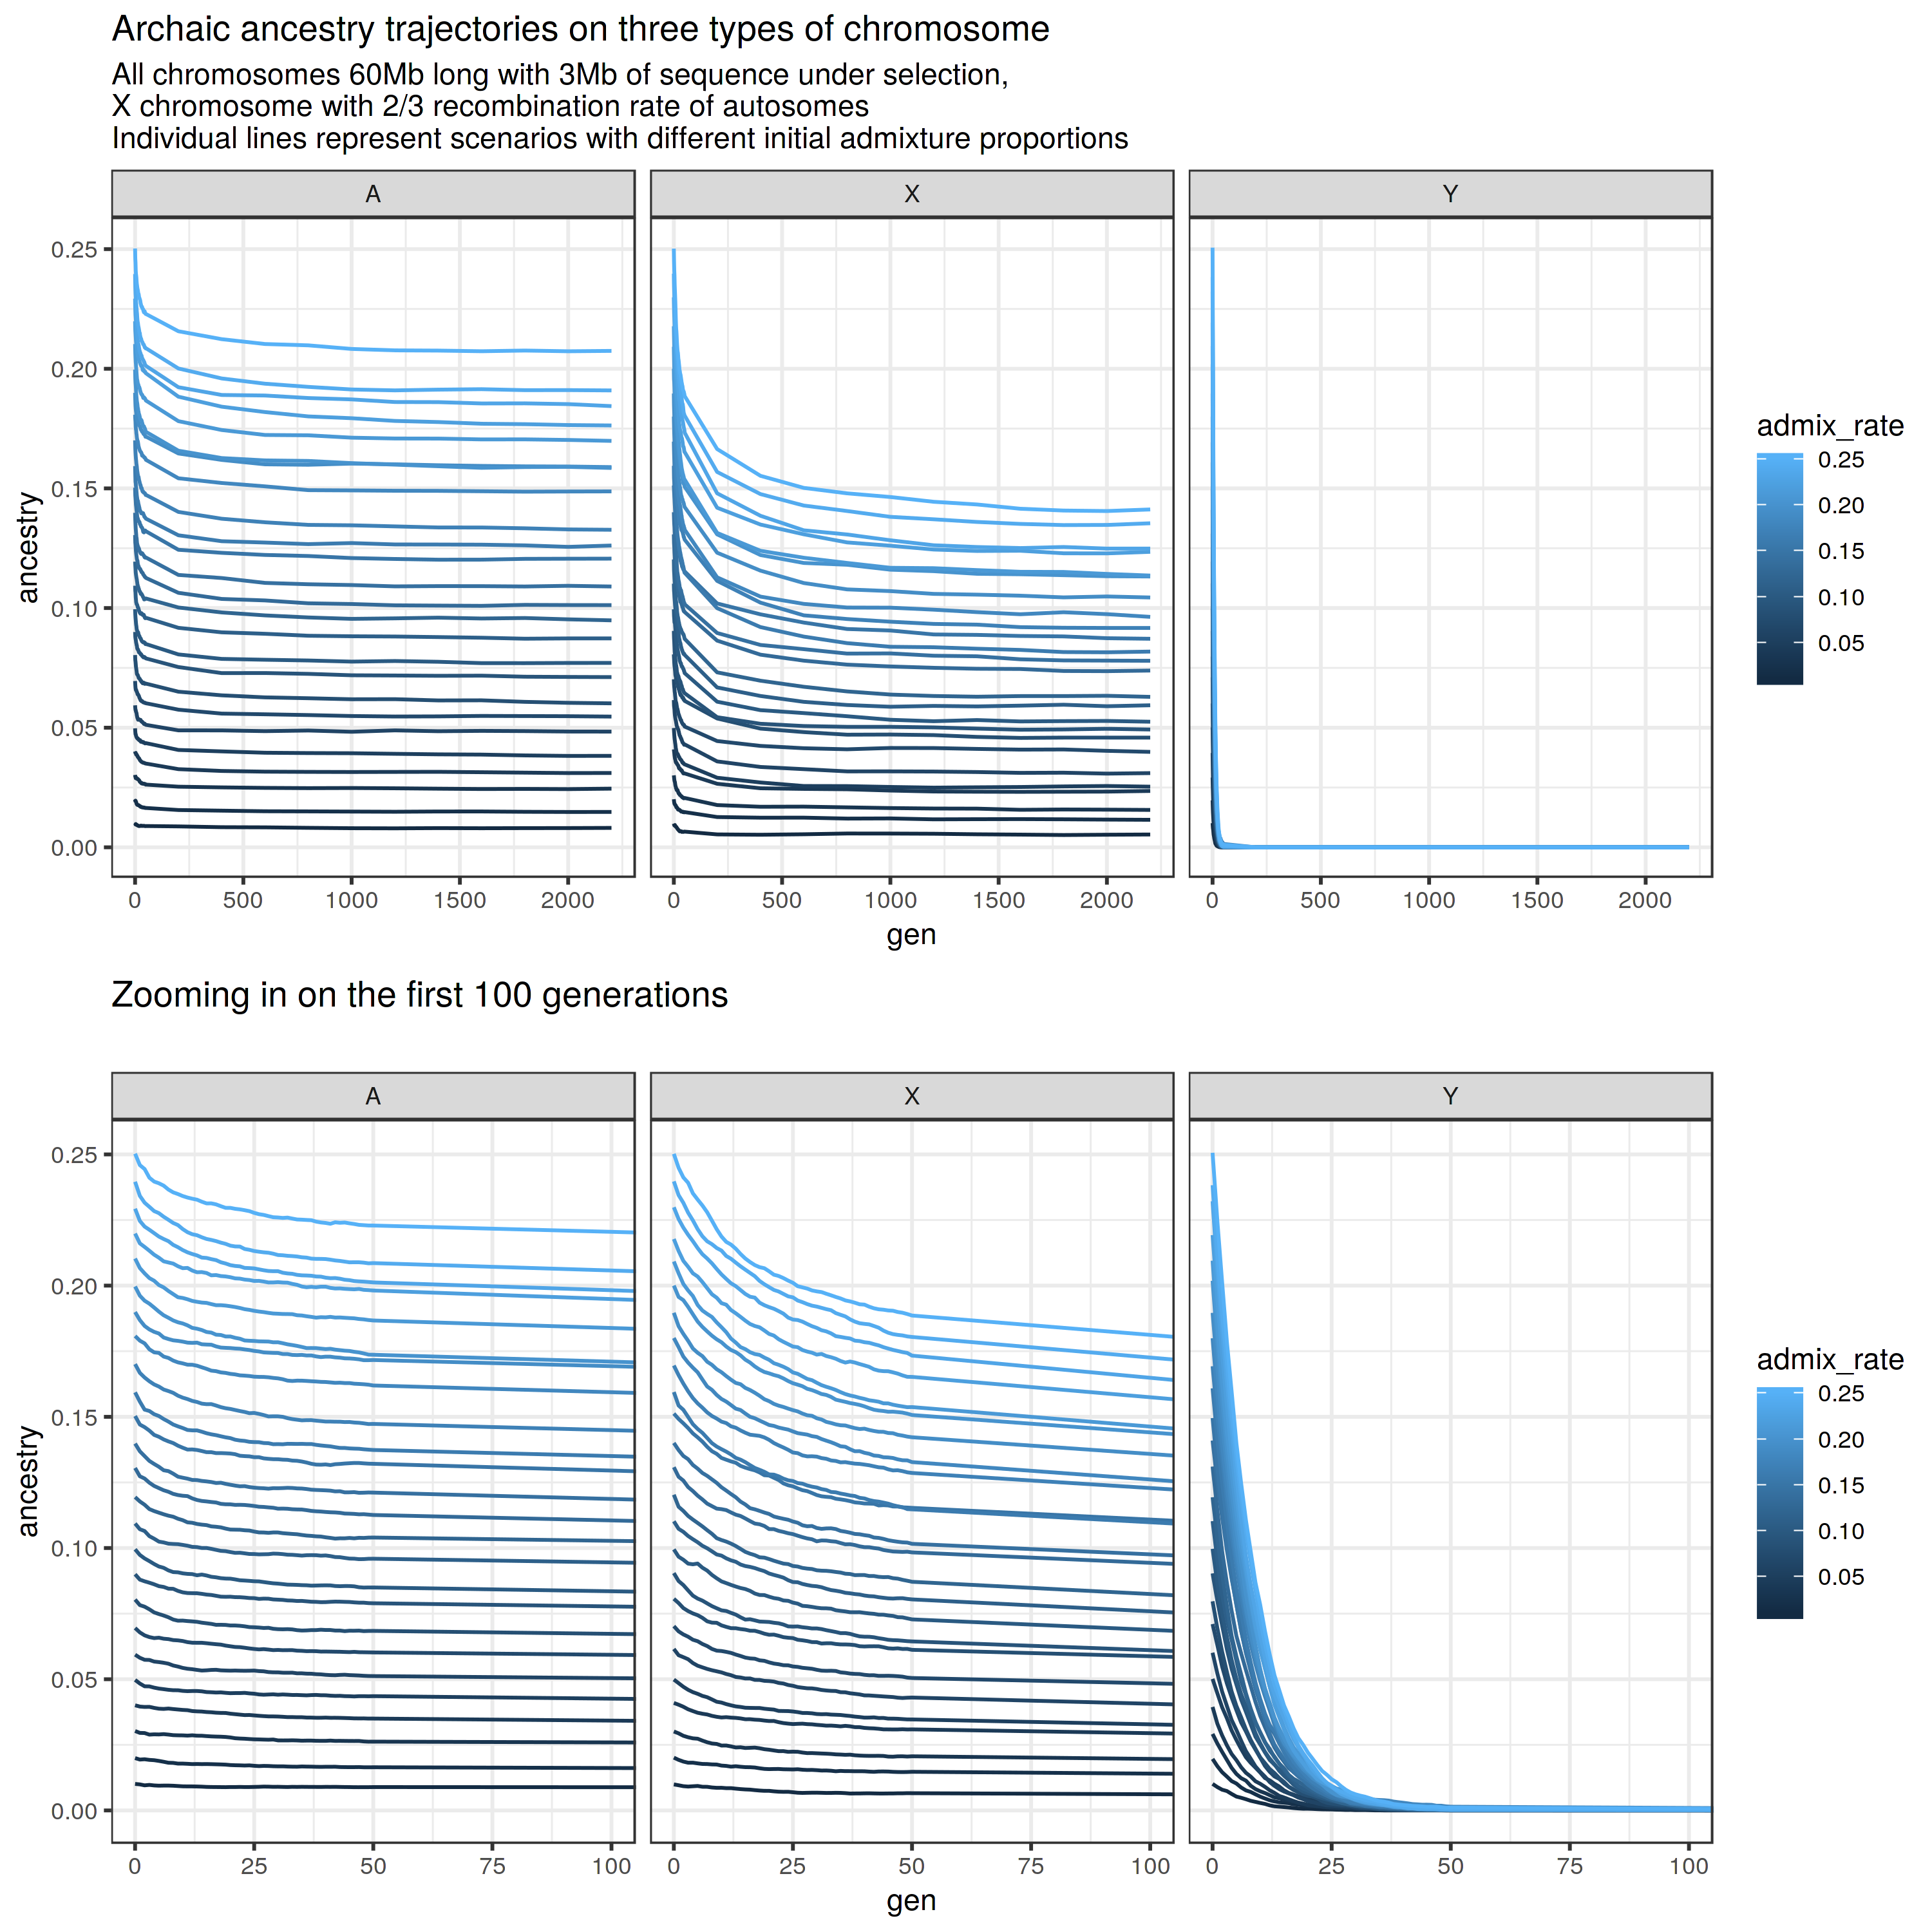

In [7]:
set_dim(10, 10, 300)

plot_grid(
    p,
    p + coord_cartesian(x = c(0, 100)) + ggtitle("Zooming in on the first 100 generations", ""),
    nrow = 2
)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


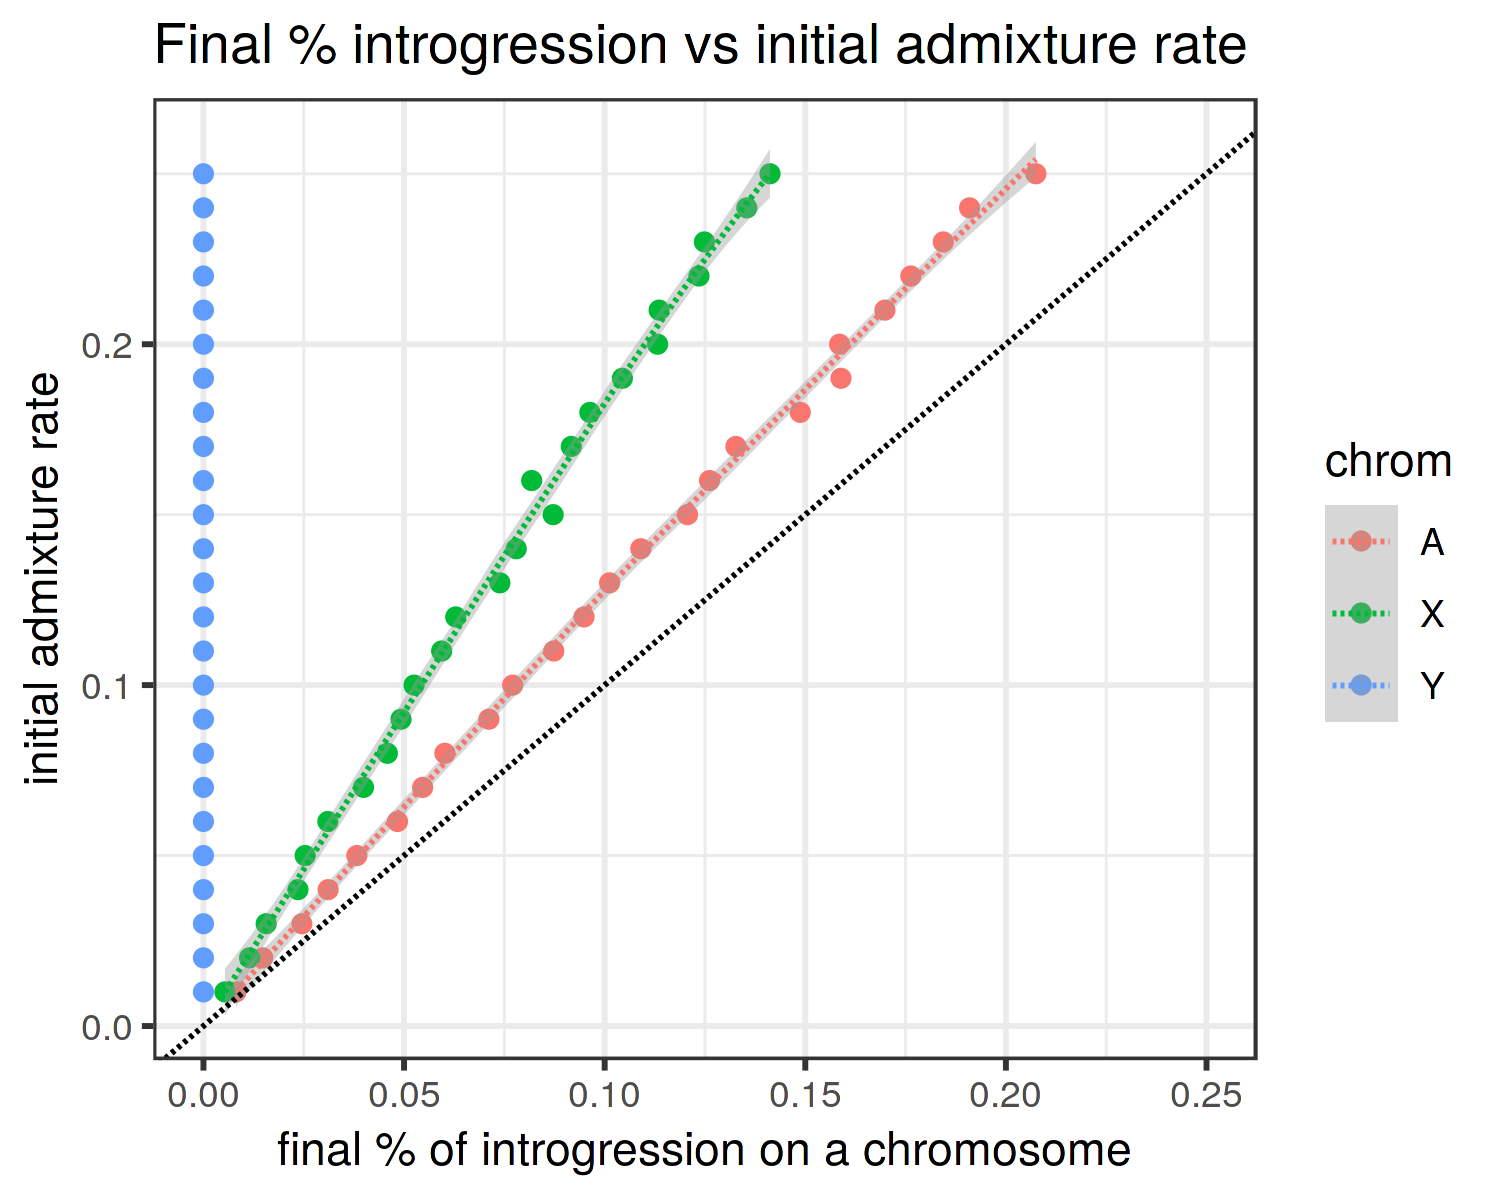

In [8]:
set_dim(5, 4, 300)

trajectories %>%
filter(direction == "archaic2modern", gen == 2200) %>%
group_by(chrom, admix_rate) %>%
summarise(proportion = mean(modern)) %>%
ggplot(aes(proportion, admix_rate, color = chrom, group = admix_rate)) +
    geom_point() +
    geom_smooth(aes(group = chrom), linetype = 2, size = 0.5) +
    geom_abline(slope = 1, linetype = 2, size = 0.5) +
    ggtitle("Final % introgression vs initial admixture rate") +
    xlab("final % of introgression on a chromosome") +
    ylab("initial admixture rate") +
    expand_limits(y = 0.25, x = 0.25) +
    theme_bw()